In [44]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline

In [45]:
"""
Get the preprocessed data:
X and y are dicts, has keys train, val and test. keys gives you what word (or pair of words) each dimension corresponds to.

You can also get bigram features if you call preprocess(bigram = True)`
Another optional argument mincount specifies the frequency cutoff for inclusion of a word/bigram in the
dictionary.

"""

X, y, keys = preprocess()

Feature size:  2049


In [46]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):  # we use the commonly used name, although it's not really a Gaussian
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [47]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        # Solve the QP problem to get the multipliers
        lagrange_multipliers = self._compute_multipliers(X, y)
        # Get all the support vectors, support weights and bias
        self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label
        """
        result = np.full(X.shape[0], self._bias) # allocate
        
        K = self._kernel_matrix(X)
        for alpha_i, y_i, k_i in zip(self._weights, self._support_vector_labels, K):
            result += alpha_i * y_i * k_i
        
        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
        """
        N, d = X.shape
        K = np.zeros((N, N))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Fills in relevant variables: model bias and weights (alphas), and details of support vectors
        
        -------
        """
        support_vector_indices = \
            lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        """
        Get the bias term (w_0)
        """
        
        K = self._kernel_matrix(support_vectors)
        weighted_ys= support_multipliers * support_vector_labels
        y_hat = np.dot(weighted_ys, K)
        Nm = np.sum(support_vector_indices)
        bias = 1/Nm * np.sum((support_vector_labels - y_hat))
        self._bias=bias
        self._weights=support_multipliers
        self._support_vectors=support_vectors
        self._support_vector_labels=support_vector_labels

    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, d = X.shape

        K = self._kernel_matrix(X)
        """
        The standard QP solver formulation:
        min 1/2 x^T H x + f^T x
        s.t.
        Ax <=  a
        Bx = b
        """
        H = cvxopt.matrix(np.outer(y, y) * K)
        f = cvxopt.matrix(-1 * np.ones(N))
        
        A_1 = cvxopt.matrix(np.diag(np.ones(N)))
        a_1 = cvxopt.matrix(np.ones(N) * self._c)
        A_2 = cvxopt.matrix(np.diag(np.ones(N) * -1))
        a_2 = cvxopt.matrix(np.zeros(N))
        
        
        A = cvxopt.matrix(np.vstack((A_2, A_1)))
        a = cvxopt.matrix(np.vstack((a_2, a_1)))

        B = cvxopt.matrix(y, (1, N))
        b = cvxopt.matrix(0.0)
        
        # call the QP solver
        solution = cvxopt.solvers.qp(H, f, A, a, B, b)

        # Lagrange multipliers (the unknown vector 'x' is our alphas)
        return np.ravel(solution['x'])

Test the trainer.
The following code would generate data which the grounth truth split is x+y = 0.5.

SV number:  6


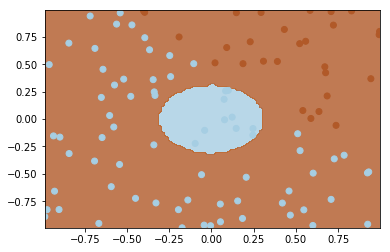

In [5]:
clf = SVM(Kernel.linear(), 100)
test_linear_SVM(clf, 100)

SV number:  12


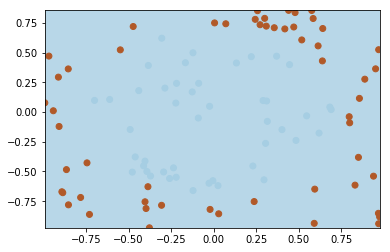

In [6]:
clf = SVM(Kernel.gaussian(1), 100)
test_rbf_SVM(clf, 100)

If you think your code is correct, then we can move to the real problem. Below are some code examples; you will need to fill in some details, and extend these to any experiments you want to run.

In [7]:
def best_model(models):
    '''
    Returns the key (C) of models dictionary with value (trAcc, valAcc)
    of maximum value (valAcc)
    '''
    key, value = max(models.items(),key=lambda x: x[1][1])
    return key, value

In [8]:
models = {}
C_RANGE = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for C in C_RANGE:
    clf = SVM(Kernel.linear(), C)
    clf.fit(scaleX(X['train']), y['train'].astype('double'))
    print("C = ", C)
    y_hat = clf.predict(scaleX(X['train']))
    print("Acc on train: ", np.mean(y_hat == y['train']))
    y_hat = clf.predict(scaleX(X['val']))
    print("Acc on val: ", np.mean(y_hat == y['val']))
    train_acc = np.mean(y_hat == y['train'])
    val_acc = np.mean(y_hat == y['val'])
    models[C] = (train_acc, val_acc)
    

SV number:  0
C =  1e-06


/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in long_scalars
/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in double_scalars


Acc on train:  0.0
Acc on val:  0.0


/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


SV number:  0
C =  1e-05
Acc on train:  0.0
Acc on val:  0.0
SV number:  2069
C =  0.0001
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2083
C =  0.001
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2090
C =  0.01
Acc on train:  0.596396396396
Acc on val:  0.672
SV number:  2090
C =  0.1
Acc on train:  0.527207207207
Acc on val:  0.588
SV number:  1732
C =  1
Acc on train:  0.519279279279
Acc on val:  0.618
SV number:  1313
C =  10
Acc on train:  0.569369369369
Acc on val:  0.662
SV number:  1087
C =  100
Acc on train:  0.52972972973
Acc on val:  0.666
SV number:  1025
C =  1000
Acc on train:  0.536216216216
Acc on val:  0.664
SV number:  1074
C =  10000
Acc on train:  0.614414414414
Acc on val:  0.654


In [9]:
best = best_model(models)
print(best)
best_C = best[0]

(0.01, (0.0, 0.67200000000000004))


Choose the best C, and predict the label for test data.

In [10]:
C = best_C
clf = SVM(Kernel.linear(), C)
clf.fit(scaleX(X['train']), y['train'].astype('double'))
y_hat = clf.predict(scaleX(X['test']))
save_submission('sub_linear.csv', y_hat)


SV number:  2052


SV number:  63


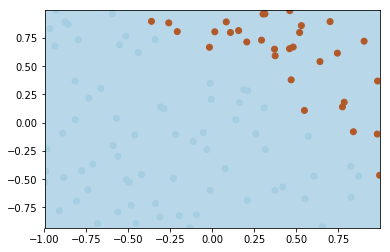

In [11]:
test_linear_SVM(clf, 100)

RBF (Gaussian) kernel SVM

In [31]:
models_rbf = {}
C_RANGE = [0.01]
GAMMA_RANGE = np.logspace(-9, 3, 4)

for C in C_RANGE:
    for gamma in GAMMA_RANGE:
        clf = SVM(Kernel.gaussian(gamma), C)
        clf.fit(scaleX(X['train']), y['train'].astype('double'))
        print("C = ", C)
        print("gamma = ", gamma)
        y_hat = clf.predict(scaleX(X['train']))
        print("Acc on train: ", np.mean(y_hat == y['train']))
        y_hat = clf.predict(scaleX(X['val']))
        print("Acc on val: ", np.mean(y_hat == y['val']))
        train_acc = np.mean(y_hat == y['train'])
        val_acc = np.mean(y_hat == y['val'])
        models_rbf[(C,gamma)] = (train_acc, val_acc)
        

SV number:  2775
C =  0.01
gamma =  1e-09
Acc on train:  0.636396396396
Acc on val:  0.67


/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


SV number:  2775
C =  0.01
gamma =  1e-05
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2104
C =  0.01
gamma =  0.1
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2775
C =  0.01
gamma =  1000.0
Acc on train:  0.636396396396
Acc on val:  0.67


In [32]:
best_rbf = best_model(models_rbf)
print(best_rbf)
best_C_rbf, best_gamma  = best_rbf[0]

((0.01, 1.0000000000000001e-09), (0.0, 0.67000000000000004))


In [33]:
clf = SVM(Kernel.gaussian(best_gamma), best_C_rbf)
clf.fit(scaleX(X['train']), y['train'].astype('double'))
y_hat = clf.predict(scaleX(X['test']))
save_submission('sub_rbf.csv', y_hat)


SV number:  2775


# Results

#### Evaluate a range of values of C (regularization parameter) and the kernel-specific parameter(s) and discuss your findings – how do these values affect the performance of the classifier on training/validation data?

The set of C evaluated for linear SVM was {0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000}.

 - Given that C is an upper bound for the lagrange multipliers, I thought it would be a good idea to explore a wide range of values to get a better sense of any subrange that was better than other.

- I also decided to normalize the features with the scaleX function, so that my features have unit length. 

- For the linear SVM, values of C greater than 1 were worse in terms of the accuracy on the validation set, and values between 0.0001 and 0.01 had a better performance.

- The best penalty C for this particular problem on the validation set for the linear SVM is:

- Linear: C = 0.01 valAcc = 0.6720

- It is interesting to note that this value of C has a relatively bad performance (compared to others) on the accuracy for the training set. Also, we see that as see increases, the accuracy on the validation set is decreasing. The only exception is the extreme value of C = 10000.

For non-linear SVM, I decided to use the optimal value for C that I found after my search, and only explore options for gamma. 

The set of values for gamma were the following {1.00000000e-09,   1.00000000e-05,   1.00000000e-01, 1.00000000e+03}

- We can think of gamma as 1/sigma, so small values of gamma imply large values for sigma and large values of gamma imply smaller values for sigma. The above set allowed me to explore the space.

- The best penalty C and value of gamma for this problem on the validation set for RBF kerel is:

- RBF: C = 0.01, gamma = 1.0000000000000001e-09, valAcc = 0.67




### Problems combining bigrams and scaling features

As part of the exploration process, I used bygrams for the linear SVM, but I was not able to do both bygrams and scaling in the same problem (I'm not sure why this is the case) and I got the following results:

In [49]:
models_bi = {}
C_RANGE = [0.00001, 0.0001, 0.001, 0.01, 0.1]
for C in C_RANGE:
    clf = SVM(Kernel.linear(), C)
    clf.fit(X['train'], y['train'].astype('double'))
    print("C = ", C)
    y_hat = clf.predict(X['train'])
    print("Acc on train: ", np.mean(y_hat == y['train']))
    y_hat = clf.predict(X['val'])
    print("Acc on val: ", np.mean(y_hat == y['val']))
    train_acc = np.mean(y_hat == y['train'])
    val_acc = np.mean(y_hat == y['val'])
    models_bi[C] = (train_acc, val_acc)

SV number:  0
C =  1e-05


/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in long_scalars
/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in double_scalars


Acc on train:  0.0
Acc on val:  0.0


/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


SV number:  2775
C =  0.0001
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2775
C =  0.001
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2775
C =  0.01
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2775
C =  0.1
Acc on train:  0.636396396396
Acc on val:  0.67


In [50]:
best_model(models_bi)

(0.0001, (0.0, 0.67000000000000004))

With this subset of values for C, we observe that the accuracy on the validation set was not better than the one we got from scaling X. The only thing that is puzzling is that the trainig accuracy seems to remain constant.

### Run at least one non-linear SVM (with some non-linear kernel)

In [51]:
new_kernel = Kernel.inhomogenous_polynomial(4)
models_ihpoly = {}
C_RANGE = [0.00001, 0.0001, 0.001, 0.01, 0.1]
for C in C_RANGE:
    print("C = ", C)
    clf = SVM(new_kernel, C)
    clf.fit(X['train'], y['train'].astype('double'))
    y_hat = clf.predict(X['train'])
    train_acc = np.mean(y_hat == y['train'])
    y_hat = clf.predict(X['val'])
    val_acc = np.mean(y_hat == y['val'])
    print("   ", train_acc, val_acc)
    models_ihpoly[C] = (train_acc, val_acc)

C =  1e-05
SV number:  0


/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in long_scalars
/Users/juanarroyo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in double_scalars


    0.0 0.0
C =  0.0001
SV number:  2775
    0.636396396396 0.67
C =  0.001
SV number:  2775
    0.636396396396 0.67
C =  0.01
SV number:  2775
    0.636396396396 0.67
C =  0.1
SV number:  2775
    0.636396396396 0.33


In [52]:
best_ihpoly = best_model(models_ihpoly)
print(best_ihpoly)
best_c_ihpoly = best_ihpoly[0]

(0.0001, (0.63639639639639645, 0.67000000000000004))


The last exercise we did this non-linear kernel with a 4th degree polynomial. The results for this model are not better than the ones we got from rbf or the linear kernel.